In [5]:
import pandas as pd
from vnstock import Vnstock,Listing, Quote, Company, Finance, Trading, Screener 
import datetime
import numpy as np
from collections import defaultdict


In [ ]:


class Stock_data:
    def __init__(self,stock:Vnstock.stock):
        self.stock = stock
        #calculate date
        
        today = datetime.date.today()
        start = today.replace(year=today.year - 5)
        end = today.replace(day=today.day - 1)
        #modify history by adding shift 1 day then remove the first row
        self.history = self.stock.quote.history(start = str(start),end = str(end),interval = "1D")
        self.history["close_shift_1"] = self.history["close"].shift(1)
        self.history = self.history.iloc[1:,:]
    def hpr(self,display_option = False):

        #calculate hpr day
        self.history["hpr"] = (self.history["close"]- self.history["close_shift_1"]) / self.history["close_shift_1"]
        if display_option:
            display(self.history)
    def arithmethic_mean(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        self.a_mean = self.history["hpr"].mean()
        return self.a_mean
    def geometric_mean(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        growth_factors = 1 + self.history["hpr"]
        self.geo_mean = np.prod(growth_factors) ** (1 / len(growth_factors)) - 1
        return self.geo_mean
    def standard_deviation(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        self.std_dev = self.history["hpr"].std()  
        return self.std_dev
    def annualize(self):
        if hasattr(self, 'std_dev') and hasattr(self, 'a_mean') and hasattr(self, 'geo_mean'):
            trading_days = 252  # typical number of trading days in a year
            annualized_mean = (1 + self.geo_mean) ** trading_days - 1
            annualized_std = self.std_dev * np.sqrt(trading_days)
            annualized_amean = self.a_mean * trading_days
            return {
                    "Annualized_arithmethic_mean": annualized_amean,
                    "Annualized_geometric_mean": annualized_mean,
                    "Annualized_std": annualized_std,
                    
            }
        else:
            raise AttributeError("Please calculate mean, geometric mean, and standard deviation before annualizing.")



In [ ]:
from collections import defaultdict
stocks = ["ACB","VCB","VIC","HPG","FPT"]
results = defaultdict(dict)
for stock in stocks:
    stock_obj = Vnstock().stock(symbol= stock,source="VCI")
    stock_data = Stock_data(stock=stock_obj)
    results["open"] = stock_data.history["open"].copy()
    results["close"] = stock_data.history["close"].copy()
    results["symbol"] = stock



In [ ]:
class Portfolio():
    def __init__(self,stocks:list,weight_list:list,start_year_previous = 5):
        #checking condition
        if len(weight_list) != len(stocks):
            raise ValueError("Length of weight_list must equal length of stocks")
        if np.sum(weight_list) != 1:
            raise ValueError("Sum of weights must equal 1")
        #setting up
        self.stocks = stocks
        self.weight_list = weight_list
        self.history = defaultdict(list)
        #getting date
        today = datetime.date.today()
        start = today.replace(year=today.year - start_year_previous)
        end = today.replace(day=today.day - 1)
        #getting historical data
        for i,stock in enumerate(self.stocks):
            stock_obj = Vnstock().stock(symbol= stock,source="VCI")
            stock_data = stock_obj.quote.history(start = str(start),end = str(end),interval = "1D")
            
            self.history["open"].append(stock_data["open"].copy())
            self.history["close"].append(stock_data["close"].copy())
            self.history["symbol"].append(stock)
            self.history["weight"].append(weight_list[i])
       
        
    def hpr(self,display_option =False):
        for i in range(len(self.stocks)):

            self.history["hpr"].append(self.history["close"][i].pct_change())
        if display_option == True:
            display(pd.DataFrame(self.history).explode(["open","close","hpr"]))
    def variance(self,display_option=False):
        hpr = pd.concat(self.history["hpr"],axis=1)
        w =np.array(self.weight_list)
        self.cov_matrix = hpr.cov()
        self.variance = float(w @ self.cov_matrix @ w)
        self.std_dev = self.variance**0.5
        return self.variance
    def correlation(self,display_option = False):
        hpr = pd.concat(self.history["hpr"],axis=1)
        corr_matrix = hpr.corr()
        corr_matrix.columns = self.stocks
        corr_matrix.index = self.stocks
        self.corr_matrix = corr_matrix
        return self.corr_matrix
portfolio = Portfolio(stocks=["ACB","VCB","FPT"],weight_list=[0.1,0.3,0.6])
portfolio.hpr(display_option=True)
portfolio.variance()
portfolio.correlation()
portfolio.corr_matrix


,open,close,symbol,weight,hpr
0,7.92,7.95,ACB,0.1,NaN
0,7.95,8.07,ACB,0.1,0.015094
0,8.1,8.03,ACB,0.1,-0.004957
0,8.03,7.95,ACB,0.1,-0.009963
0,7.95,7.92,ACB,0.1,-0.003774
...,...,...,...,...,...
2,100.6,100.3,FPT,0.6,-0.00199
2,100.1,97.7,FPT,0.6,-0.025922
2,97.7,101.7,FPT,0.6,0.040942
2,101.6,99.0,FPT,0.6,-0.026549


defaultdict(list,
            {'open': [0        7.92
              1        7.95
              2        8.10
              3        8.03
              4        7.95
                      ...  
              1238    27.05
              1239    28.50
              1240    28.30
              1241    29.00
              1242    28.20
              Name: open, Length: 1243, dtype: float64,
              0       36.49
              1       36.32
              2       36.36
              3       36.53
              4       36.10
                      ...  
              1243    64.50
              1244    64.50
              1245    63.30
              1246    64.00
              1247    65.80
              Name: open, Length: 1248, dtype: float64,
              0        21.32
              1        21.07
              2        21.93
              3        21.80
              4        21.62
                       ...  
              1243    100.60
              1244    100.10
              

<Axes: >

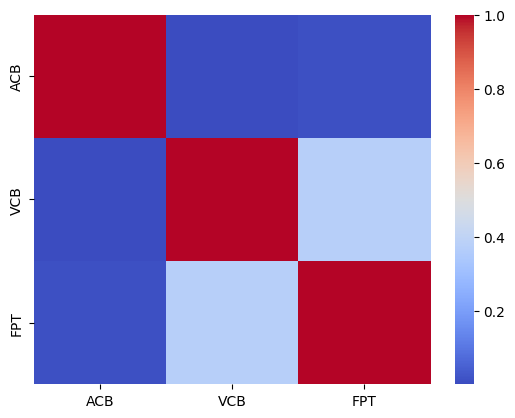

In [71]:
import seaborn as sns
portfolio.variance
sns.heatmap(data=portfolio.corr_matrix,cmap="coolwarm")